# Part 1

## Task 1.1: Estimating Generation Time

In [37]:
#Importing libraries and modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from statsmodels.formula.api import glm
import statsmodels.formula.api as smf
from statsmodels.api import families
import warnings
import itertools
import matplotlib.dates as mdates
from IPython.display import display
warnings.filterwarnings("ignore") #they 

### a. Importing contact tracing data

In [38]:
#Reading and saving csv
contact_tracing = pd.read_csv("contact_tracing.csv")

### b. Summarising and plotting data.


Summary statistics:


,incub,infec,bites
count,200.00000,200.000000,200.000000
mean,23.28000,3.540000,2.270000
std,22.53287,2.083291,2.569066
min,1.00000,1.000000,0.000000
25%,9.00000,2.000000,1.000000
50%,16.00000,3.000000,1.000000
75%,28.00000,4.000000,3.000000
max,152.00000,13.000000,19.000000


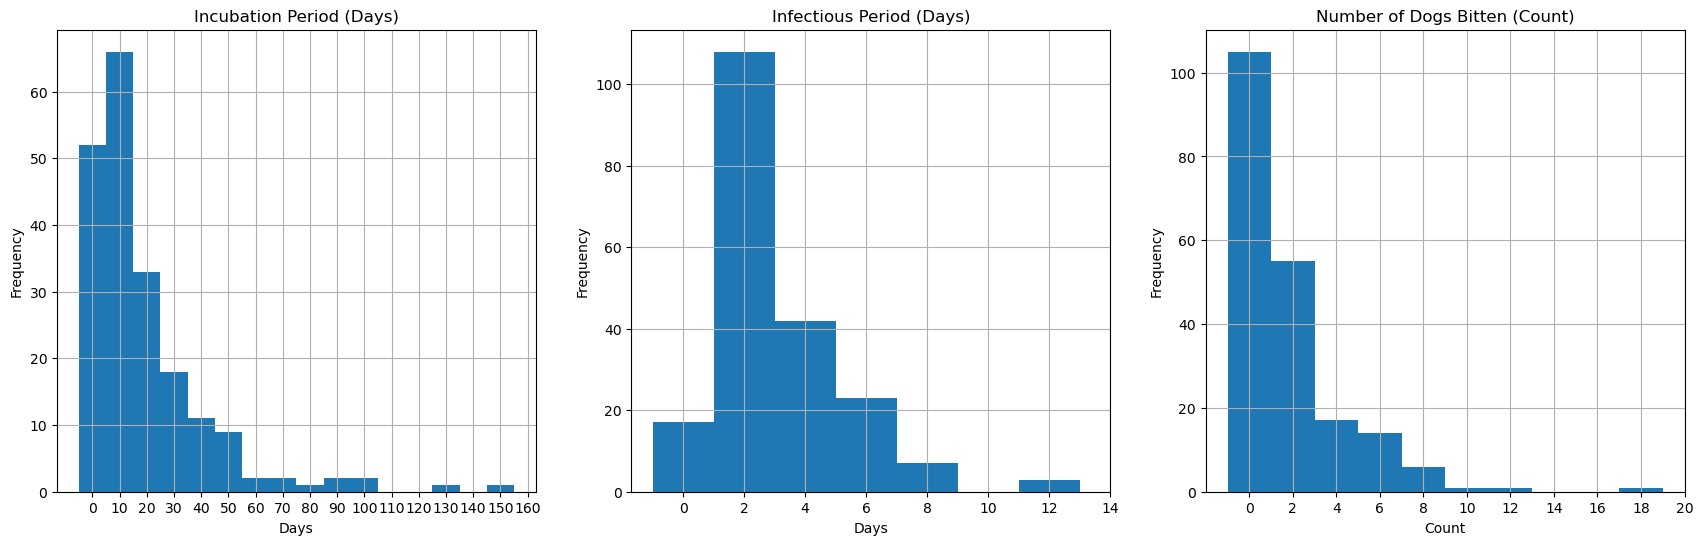

In [39]:
#Using .describe to give a stats summary of 
print("\nSummary statistics:")
display(contact_tracing.describe())

# The ticks and bars were odd so this function cleans them up.
def bins_and_ticks(series, bins_space):
    max_val = int(series.max())
    #This could be done dynamically but all of the data starts at close to 0 so I've hardcoded 0
    # and added an argument for bins space so that the program can be manually customised easily.
    return np.arange(0, max_val + bins_space, bins_space) 

# Setting up subplots - Using left alignment so that the bars sit in the middle of the ticks.
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

#Setting up what's needed for an efficient loop
data_labels = ["incub", "infec", "bites"] #Storing variables in a list so that they can be looped through. 
#Using a dictionary to map variable name to what the title 
mappings_for_labels = {
    "incub": ("Incubation Period", "Days", 10),
    "infec": ("Infectious Period", "Days", 2),
    "bites": ("Number of Dogs Bitten", "Count", 2)
}

for ax, label in zip(axes, data_labels):
    title, data_type, bins_space = mappings_for_labels[label]
    bins = bins_and_ticks(contact_tracing[label], bins_space)
    contact_tracing[label].hist(ax=ax, bins=bins, align="left")
    ax.set_title(f"{title} ({data_type})")
    ax.set_xlabel(data_type)
    ax.set_ylabel("Frequency")
    ax.set_xticks(bins)


# Completing final layout with tight layout and saving them to figures directory.
plt.savefig("figures/variable_histograms.png")

### c. Plotting data and using stats test  to see if the variables differ in each district.
I used box plots here since they present the data in such a way which allows for the values and spread of the data to be easily compared.

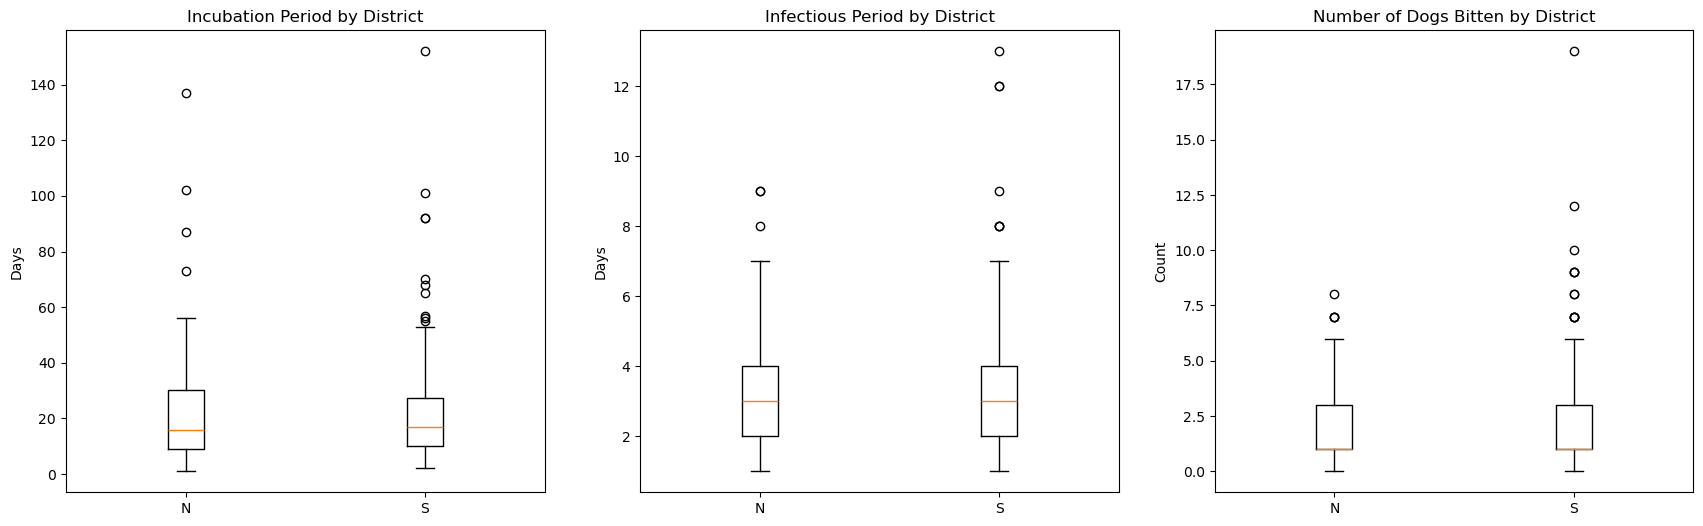

In [40]:
# Using box plots as they allow for clear and quick comparision between variables

# Group once by district, creates a dictionary
grouped_contacts = contact_tracing.groupby("district")

# 1) Box‐plots by district
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, label in zip(axes, data_labels):
    # Getting data from groups and turning them into a list from the dictionary
    data_by_group = grouped_contacts[label].apply(list)
    # Plotting, plus labels and titles
    ax.boxplot(data_by_group.values, labels=data_by_group.index)
    title, data_type, _ = mappings_for_labels[label]
    ax.set_title(f"{title} by District")
    ax.set_ylabel(data_type)
#Saving to figures directory
plt.savefig("figures/boxplots_by_district.png")


#### Testing if any of the variables differ between the two districts:
In order to test  whether any of the variables differed between the districts, I had to decide on which test to use. 

**Normality:**
I used Q-Q plots and the Shapiro-Wilks test in order to test the normality of the data. Both demonstrated that the data is not normally distributed. 

See plots and code for all tests below.

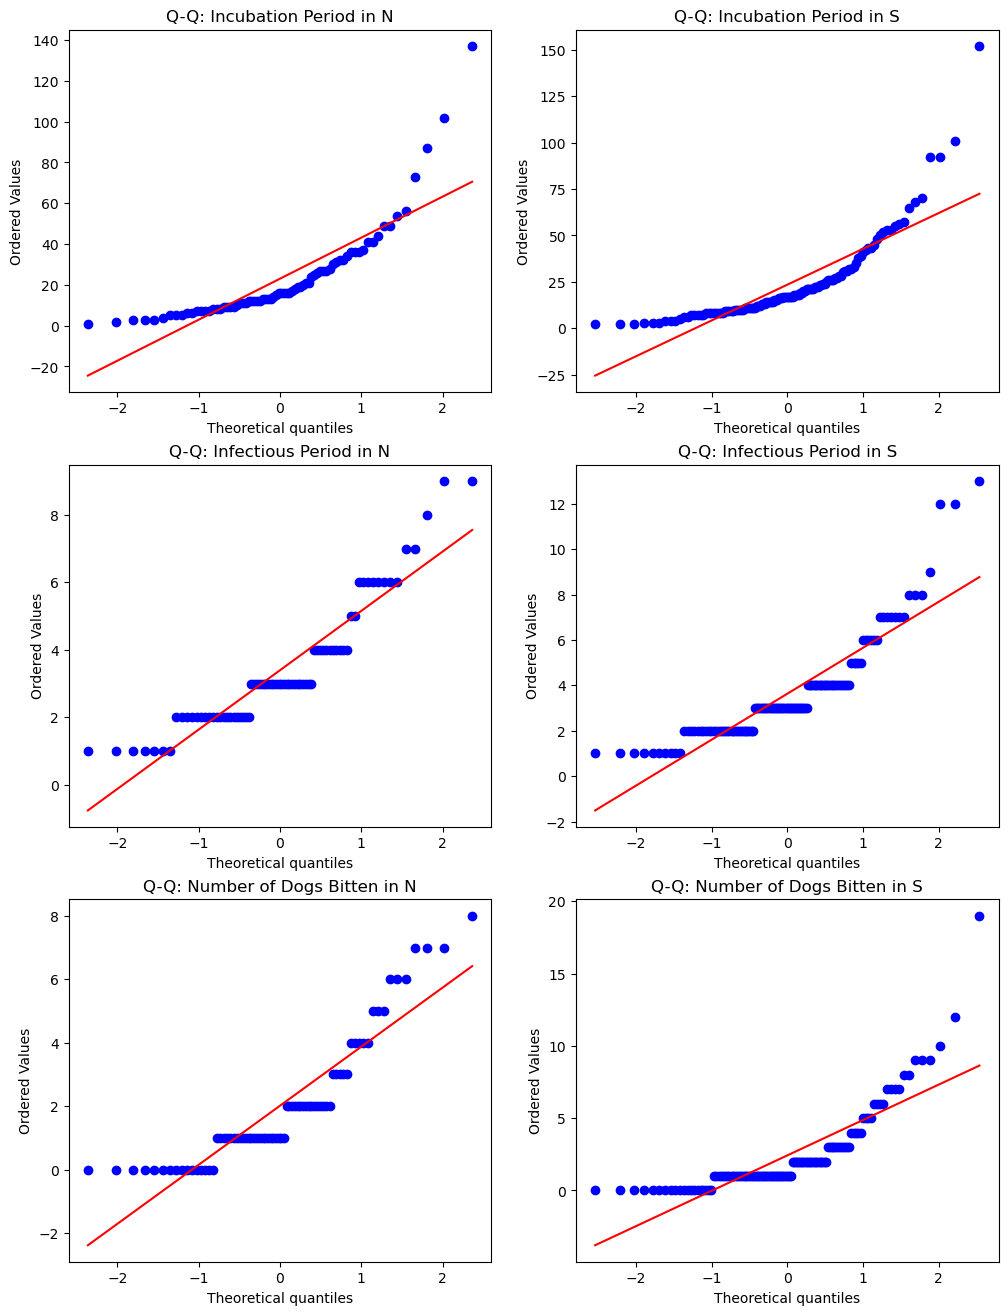

In [41]:
#Plotting Q-Q plots and performing Shapiro-Wilk normality test, Levene's equal variance test and finally Mann Whittney U test.
# Setting up lists for tests
normality_results = []
levene_results = []
mw_results = []
raw_pvals = []
# Setting up subplot axis for Q-Q plots
fig, axes = plt.subplots(len(data_labels), 2, figsize=(12, 16))
districts = ["N","S"]
#Iterating through columns.
for i, label in enumerate(data_labels):
    #Using mappings for labels of plot.
    title, data_type, _ = mappings_for_labels[label]
    #Now iterating through districts for normality test.
    for j, district in enumerate(districts):
        # Selecting district and variable specific data
        data = grouped_contacts.get_group(district)[label]
        
        # Creating Q-Q plot using data
        ax = axes[i, j]
        stats.probplot(data, dist='norm', plot=ax)
        ax.set_title(f"Q-Q: {title} in {district}")
        
        # Performing Shapiro-Wilk test
        W, p = stats.shapiro(data)
        #Saving results in structured format for later display.
        normality_results.append({
            'variable': title,
            'district': district,
            'W': W,
            'p_value': p,
            'normal (α=0.05)': p > 0.05
        })
    # Get data for each district for Levene's and Mann-Whitney U test.
    n_data = grouped_contacts.get_group('N')[label]
    s_data = grouped_contacts.get_group('S')[label]
    
    # Performing Levene's test
    stat, p = stats.levene(n_data, s_data)
    #Saving results in structured format for later display.
    levene_results.append({
        'variable': title,
        'Levene_stat': stat,
        'p_value': p,
        'equal variances (α=0.05)': p > 0.05
        })
    # I initially wrote my Mann-Whitney U test code in its own loop but I included it in here to reduce the volume of my code.
    #Performing Mann-Whitney U test and saving data for Bonferroni correction.
    U, p = stats.mannwhitneyu(n_data, s_data, alternative='two-sided')
    raw_pvals.append(p)
    
    mw_results.append({
        'variable': title,
        'U_statistic': U,
        'raw_p': p
    })

plt.show()



In [42]:
# Displaying results from Shapiro-Wilk test to test normality.
normality_df = pd.DataFrame(normality_results)
print("\nNormality (Shapiro-Wilk):")
display(normality_df)


Normality (Shapiro-Wilk):


,variable,district,W,p_value,normal (α=0.05)
0,Incubation Period,N,0.738095,2.481440e-10,False
1,Incubation Period,S,0.742234,1.812275e-13,False
2,Infectious Period,N,0.870176,1.386215e-06,False
3,Infectious Period,S,0.815707,3.614019e-11,False
4,Number of Dogs Bitten,N,0.834517,9.081661e-08,False
5,Number of Dogs Bitten,S,0.722112,5.127257e-14,False


**Standard Variance:**
Additionally, I used Levene's test to test whether the variance between regions was different. This demonstrated that it was not different between regions.
See Results Below.

In [43]:
# Displaying results from Levene's test to test if variance is equal.
levene_df = pd.DataFrame(levene_results)
print("Levene's Test Results:")
display(levene_df)

Levene's Test Results:


,variable,Levene_stat,p_value,equal variances (α=0.05)
0,Incubation Period,0.054338,0.815921,True
1,Infectious Period,0.459016,0.498875,True
2,Number of Dogs Bitten,0.845871,0.358842,True


**Deciding on a Test:**
Finally, since I am comparing the variables in two independent groups which are not normally distributed, I used a Mann-Whitney U test to compare the variables in the two populations.

**Bonferri Correction:**
Additionally, I used the Bonferri correction in order to take into account that I was performing multiple tests.

**Results:**
 The test demonstrated that there is not suffient evidence to suggest that there is a significant difference in infectious period, incubation period and number of dogs bitten in the two different populations.

In [44]:
# Displaying Mann-Whitney U tests with Bonferroni correction since we're running multiple tests. 
# Apply Bonferroni correction
test_result, p_adjusted, _, _ = multipletests(raw_pvals, method='bonferroni', alpha=0.05)

# Adding adjusted p-values to results
for i in range(len(mw_results)):
    mw_results[i]['p_bonferroni'] = p_adjusted[i]
    mw_results[i]['significant (α=0.05)'] = test_result[i]

mw_df = pd.DataFrame(mw_results)
print("\nMann-Whitney U (with Bonferroni correction):")
display(mw_df)




Mann-Whitney U (with Bonferroni correction):


,variable,U_statistic,raw_p,p_bonferroni,significant (α=0.05)
0,Incubation Period,4529.0,0.645831,1.0,False
1,Infectious Period,4481.5,0.553352,1.0,False
2,Number of Dogs Bitten,4475.5,0.541256,1.0,False


### d. Visualising the pairwise associations between variations and testing for correlation.
Below is my code for the scatter plots for each pair of variables. Below each pair of variables is the Pearson Correlation Coeffecient Tests below the respective plots. 

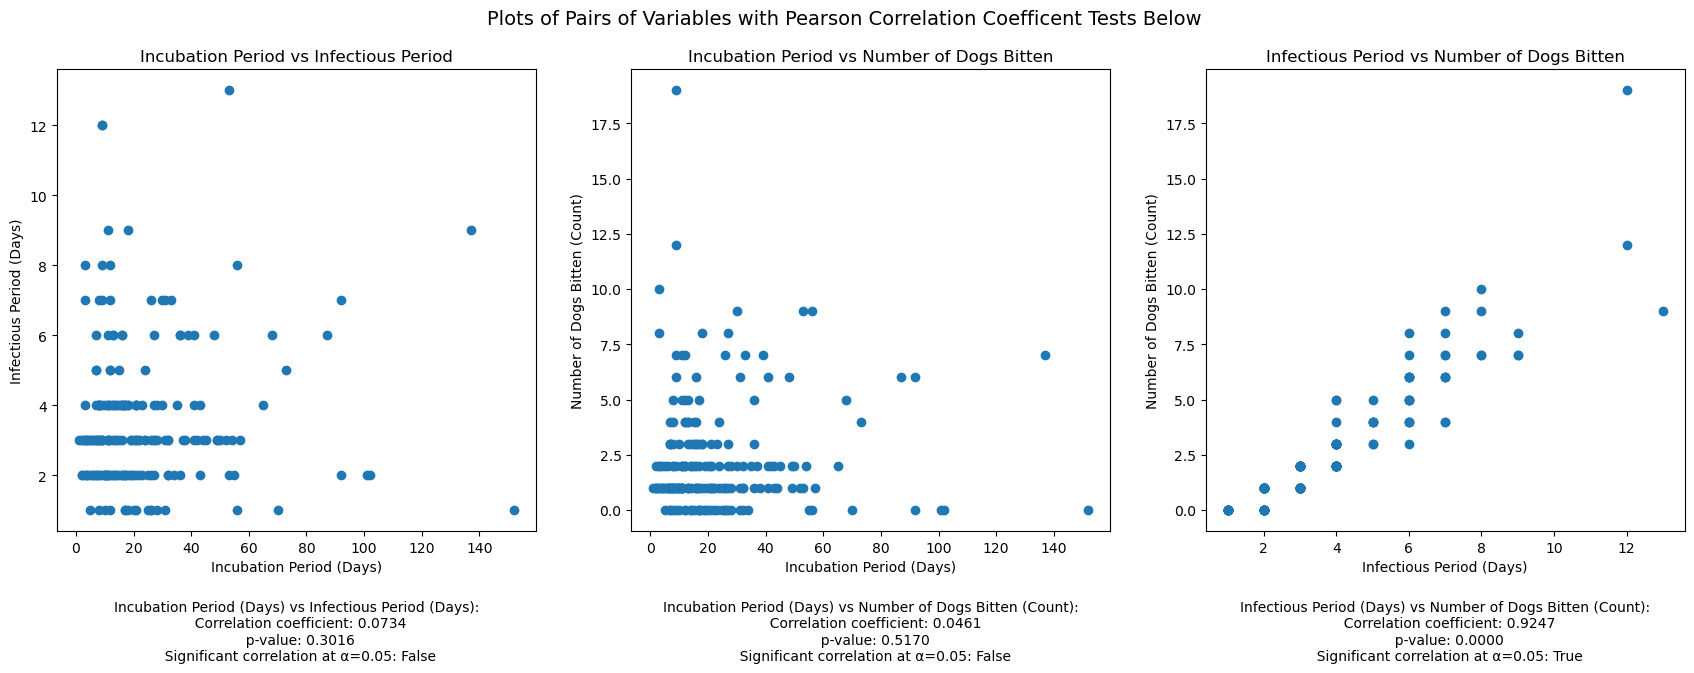

In [45]:
# generating unique pairs of variables using itertools comb function
variables_pairs = list(itertools.combinations(data_labels, 2))

# Making subplots
fig, axes = plt.subplots(1, len(variables_pairs), figsize=(21, 6))
# add adding title for all the plots
fig.suptitle("Plots of Pairs of Variables with Pearson Correlation Coefficent Tests Below", fontsize=14)

for ax, (x_label, y_label) in zip(axes, variables_pairs):
    # pulling out the bits I need for the figure and data columns
    x_title, x_unit, _ = mappings_for_labels[x_label]
    y_title, y_unit, _ = mappings_for_labels[y_label]
    # making scatter
    ax.scatter(contact_tracing[x_label], contact_tracing[y_label])
    # making title and labels
    ax.set_title(f"{x_title} vs {y_title}")
    ax.set_xlabel(f"{x_title} ({x_unit})")
    ax.set_ylabel(f"{y_title} ({y_unit})")
    # calculate Pearson correlation
    corr_coef, p_value = stats.pearsonr(contact_tracing[x_label], contact_tracing[y_label])

    # making annotation for pearson correlation coef
    annotation = f"{x_title} ({x_unit}) vs {y_title} ({y_unit}):\n  Correlation coefficient: {corr_coef:.4f}\n  p-value: {p_value:.4f}\n  Significant correlation at α=0.05: {p_value < 0.05}"
    ax.text(0.5,-0.15,annotation, transform = ax.transAxes, ha = "center", va = "top")

plt.savefig("pairwise_scatterplots.png")
plt.show()

**The Appropriateness of the Pearson's Correlation Coefficient Test**
The use of a Pearson's correlation coefficient test here is inappropriate since it assumes normality of the data. We can see from our above Q-Q plots that the data is not normally distributed and thus the pearson's correlation coefficient test is not appropriate. There are also a substantial quantity of outliers in our plots which does not suit the Pearson's test since it outliers can have a particularly significant effect on this test. Since we our using non-normal data, I would suggest using a Spearman's rank correlation coefficient test since this is better at dealing with non-normal data and is also better at dealing with significant outliers since it is a rank based test. It may also be recommended to remove some the outliers in the data, perhaps those which are over 1.5 IQRs from the median, for either test.

### e. Estimating the mean, standard error (SE) and 95% Confidence Interval (CI) of the Generation Time.

In [46]:
#Calculating and displaying the mean, SE, and 95% CI 
# creating a column for generation time
# generation time = incubation time + infectious period
contact_tracing["generation_time"] = contact_tracing["incub"] + contact_tracing["infec"]

# calculating: mean, standard error, and 95% CI
gen_time_mean = contact_tracing["generation_time"].mean()
gen_time_se = contact_tracing["generation_time"].std() / np.sqrt(len(contact_tracing))
gen_time_ci = stats.t.interval(0.95, len(contact_tracing)-1, gen_time_mean, gen_time_se)

#Printing all of the figures to 2 sig. figs.
print("Generation Time Summary")
print(f"Mean: {gen_time_mean:.2f} days")
print(f"Standard Error: {gen_time_se:.2f} days")
print(f"95% Confidence Interval: ({gen_time_ci[0]:.2f}, {gen_time_ci[1]:.2f}) days")

Generation Time Summary
Mean: 26.82 days
Standard Error: 1.61 days
95% Confidence Interval: (23.64, 30.00) days


## Task 1.2 Estimate the growth rate and $R_0$.
Information Given in Project Instructions:
To estimate the growth rate, we are going to use Poisson regression, a generalized linear model with a log link function. Specifically, we assume that case reports at time $t$ follow a Poisson distribution with mean

$$
\mu_t \;=\; Y_0 e^{r t}.
$$

Given a vector of case reports $\{x_0, x_1, \ldots, x_{n-1}\}$, the likelihood of the model is

$$
L(Y_0, r)
\;=\;
\prod_{t=0}^{n-1}
\frac{\mu_t^{\,x_t}\,e^{-\mu_t}}{x_t!}
\;=\;
\prod_{t=0}^{n-1}
\frac{\bigl(Y_0 e^{r t}\bigr)^{x_t}
      e^{-Y_0 e^{r t}}}{x_t!}.
$$

### a. Importing and plotting the monthly case reports for the Ngorogoro and Serengeti districts.

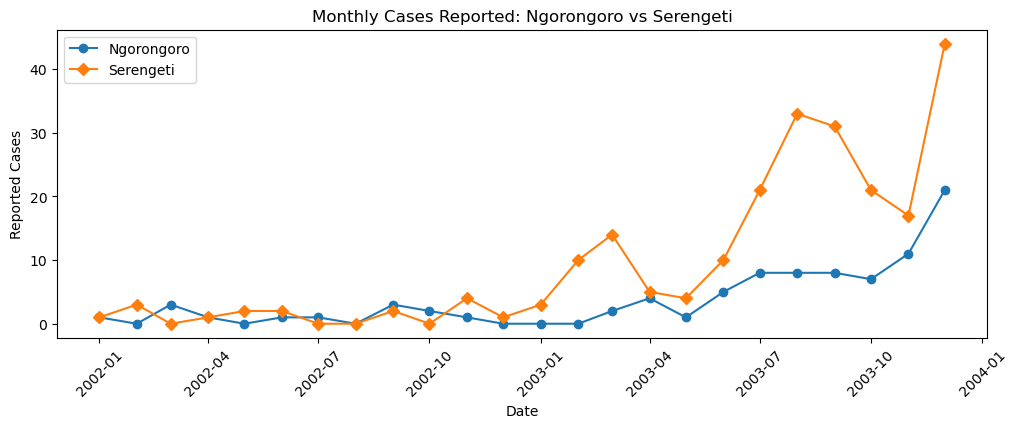

In [47]:
# Importing
case_reports = pd.read_csv("case_reports.csv")
#Inspecting
# display(case_reports_raw.head())
#Plotting
plt.figure(figsize=(12, 4))
case_reports['Date'] = pd.to_datetime(case_reports['Date'], format='%d/%m/%Y')
plt.plot(case_reports["Date"], case_reports["Ngorongoro"], marker = "o", label = "Ngorongoro")
plt.plot(case_reports["Date"], case_reports["Serengeti"], marker = "D", label = "Serengeti")
plt.xlabel('Date')
plt.ylabel('Reported Cases')
plt.title('Monthly Cases Reported: Ngorongoro vs Serengeti')
plt.legend()
plt.xticks(rotation=45)
plt.show()







### b. Creating a new column containing the number of days since 1/1/2002

In [48]:
start_date = pd.Timestamp("2002-01-01")
case_reports["Time_Since_Start"] = (case_reports["Date"] - start_date).dt.days
display(case_reports.head())

,Date,Ngorongoro,Serengeti,Time_Since_Start
0,2002-01-01,1,1,0
1,2002-02-01,0,3,31
2,2002-03-01,3,0,59
3,2002-04-01,1,1,90
4,2002-05-01,0,2,120


### c. Writing a function that calculates the log-likelihood of the model with two unknown parameters $Y_0$ and r for a given dataset consiting of a vector of time points and vector of rabies case numbers.

In [49]:
#Calculating the NEGATIVE log likelihood (since we're putting into a mimising function later). I know this is not what is specifically requested but it's useful for d.
def poisson_log_likelihood(params, times, cases):
    Y0, r = params
    # calculating mu
    mu = Y0 * np.exp(r * times) 
    return -np.sum(stats.poisson.logpmf(cases, mu)) #just remove the - to make it positive log likelihood

### d. Estimating $Y_0$ and r for each district by maximum likelihood

In [50]:
#Initialising results dict, and areas list
results = {} 
areas = ["Ngorongoro", "Serengeti"]

#start time delta is the same for both so is out of loop
times = case_reports["Time_Since_Start"].values

for area in areas:
    #getting cases from that specific area
    cases = case_reports[area].values
    # initial guess [Y0, r] for nelder-mead algorithm
    initial_params = [0.4, 0.01]
    # minimize negative log‐likelihood (Maximising Log Likelihood)
    result = minimize(poisson_log_likelihood, initial_params, args=(times, cases), method="Nelder-Mead")
    #extracting Y0 and R MLEs and saving them
    Y0_hat, r_hat = result.x
    results[area] = {"Y0": Y0_hat, "r": r_hat}
    #printing results to 6 dp.
    print(f"\nMLEs for {area}:")
    print(f"Y0 = {Y0_hat:.6f}\nr  = {r_hat:.6f}")




MLEs for Ngorongoro:
Y0 = 0.274269
r  = 0.005637

MLEs for Serengeti:
Y0 = 0.543201
r  = 0.006130


### e. Checking results using a glm

In [51]:
#iterating through areas
for area in areas:
    #taking a slice of the columns we need and giving them more friendly names
    area_data = case_reports[["Time_Since_Start", area]]
    area_data = area_data.rename(columns={"Time_Since_Start": "days_count", area: "area_cases"})
    
    #fitting Poisson GLM  log(cases) = Intercept + days_count * r
    poisson_glm = smf.glm(formula="area_cases ~ days_count",data=area_data, family=families.Poisson()).fit()
    
    #saving params and confidence interval
    log_Y0 = poisson_glm.params["Intercept"]
    r_glm  = poisson_glm.params["days_count"]
    ci = poisson_glm.conf_int().loc["days_count"]
    #also storing back into results for plotting later
    results[area]["glm_Y0"] = np.exp(log_Y0)
    results[area]["glm_r"] = r_glm
    results[area]["glm_r_ci"] = (ci[0], ci[1])
    
    #printing everything out
    # print(f"\nGLM Poisson regression summary for {area}:")
    # print(poisson_glm.summary()) #print summary if you so desire.
    print(f"\nY0 (from GLM): {np.exp(log_Y0):.6f}")
    print(f"r (from GLM): {r_glm:.6f}")
    print(f"95% CI for r: ({ci[0]:.6f}, {ci[1]:.6f})")




Y0 (from GLM): 0.274284
r (from GLM): 0.005637
95% CI for r: (0.004242, 0.007032)

Y0 (from GLM): 0.543184
r (from GLM): 0.006130
95% CI for r: (0.005223, 0.007038)


**Comparing Results**
| Region       | MLE $Y_0$  | GLM $Y_0$ | MLE $r$    | GLM $r$    | 95% CI for $r$        |
|-------------:|-----------:|----------:|-----------:|-----------:|-----------------------|
| Ngorongoro   | 0.274269   | 0.274284 | 0.005637   | 0.005637   | (0.004242, 0.007032)  |
| Serengeti    | 0.543201   | 0.543184 | 0.006130   | 0.006130   | (0.005223, 0.007038)  |

These results show that my MLE and GLM estimates for $Y_0$ and $r$ are in agreement to ~4 decimal places. This suggests that both estimates have been obtained using the correct method.

### f. Plotting the Predicted Exponential Dynamics with the Observed Data for Each District

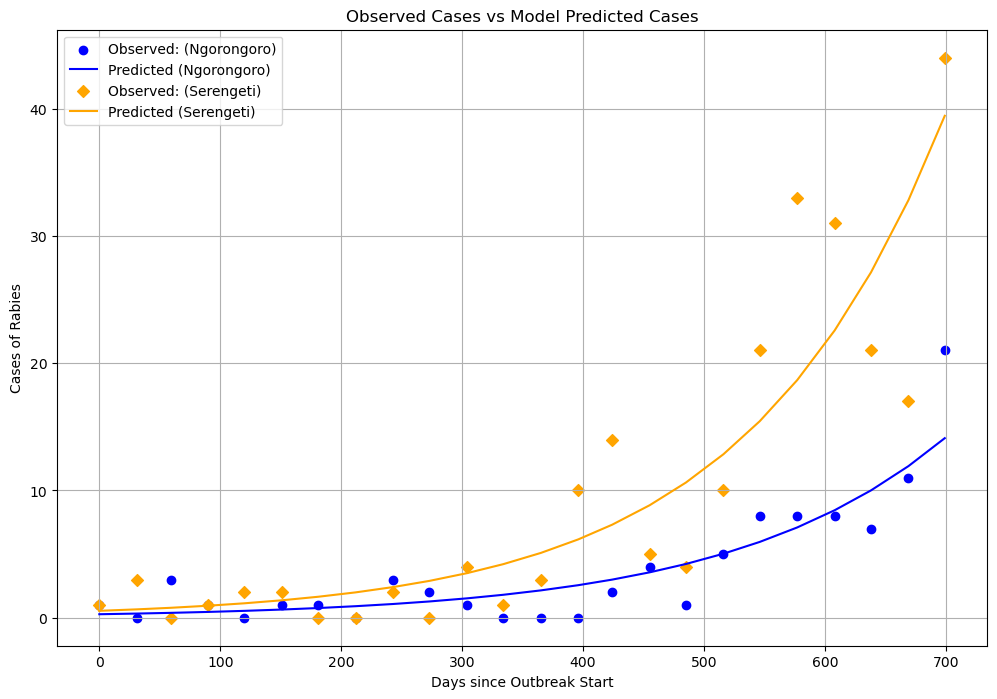

In [52]:
# Making dictionary so that I can loop through easily
styles = {
    "Ngorongoro": {"colour":"blue",  "marker":"o"},
    "Serengeti":  {"colour":"orange",   "marker":"D"}
}

#Plotting data by iterating through areas and their values.
plt.figure(figsize=(12,8))

for area in areas:
    obs_cases = case_reports[area].values
    Y0, r    = results[area]["glm_Y0"], results[area]["glm_r"]
    colour   = styles[area]["colour"] #Using mapping for the colour 
    marker   = styles[area]["marker"] #Using mapping for the markers 
    
    # plotting scatter of observed cases
    plt.scatter(times, obs_cases,color=colour, marker=marker,label=f"Observed: ({area})")
    
    # plotting line for predicted model
    plt.plot(times, Y0 * np.exp(r*times),color=colour, linestyle="-", label=f"Predicted ({area})")

# setting up labels and title
plt.xlabel("Days since Outbreak Start")
plt.ylabel("Cases of Rabies")
plt.title("Observed Cases vs Model Predicted Cases")
plt.legend()
plt.grid(True) #grid is nicer with the scatter plot
plt.show()




### g. Calculating $R_0$ for each district

In [53]:
#using:
#   gen_time_mean = mean of generation time from 1.1 e)

#extracting gen time lower and upper bounds
gen_time_low_bound, gen_time_high_bound = gen_time_ci

for area in areas:
    # growth‐rate summary from Task 1.2.e
    r_hat = results[area]["glm_r"]
    r_low_bound, r_high_bound = results[area]["glm_r_ci"]
    # point estimate
    R0_hat = np.exp(r_hat * gen_time_mean)
    #combining the lower bound of r with lower bound of mean gen time, and upper with upper in order to get a conservative 95% CI for r and R0
    R0_low_bound = np.exp(r_low_bound * gen_time_low_bound)
    R0_high_bound = np.exp(r_high_bound * gen_time_high_bound)
    
    results[area]["R0"]     = R0_hat
    results[area]["R0_ci"]  = (R0_low_bound, R0_high_bound)
    
    print(f"\n{area}:")
    print(f"r  = {r_hat:.6f} -  95% CI = ({r_low_bound:.6f}, {r_high_bound:.6f})")
    print(f"R₀ = {R0_hat:.3f}, -  95% CI = ({R0_low_bound:.3f}, {R0_high_bound:.3f})")



Ngorongoro:
r  = 0.005637 -  95% CI = (0.004242, 0.007032)
R₀ = 1.163, -  95% CI = (1.106, 1.235)

Serengeti:
r  = 0.006130 -  95% CI = (0.005223, 0.007038)
R₀ = 1.179, -  95% CI = (1.131, 1.235)


### h. Using the previous data to find if there is evidence that r and $R_0$ differ between the two districts

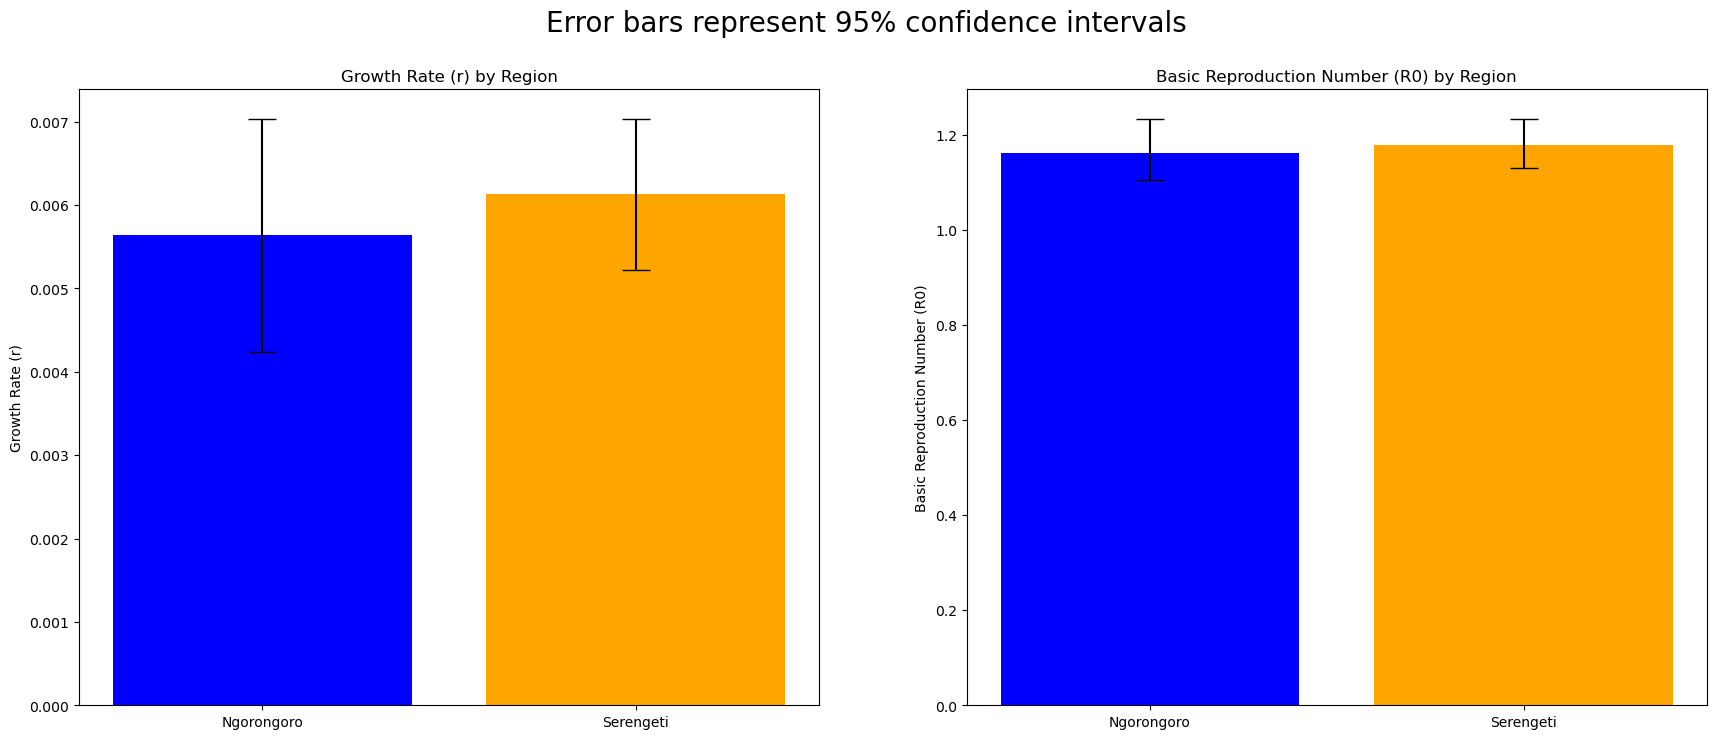

In [54]:
#Plotting bar charts in order to demonstrate the values of r and R_0 and their error bars.
# Creating two subplots
fig, ax = plt.subplots(1, 2, figsize=(21, 8))

# Setting up axis positions and initiating lists for r and R0 vals
positions = np.arange(len(areas))
r_values = []
r_errors_lower = []
r_errors_upper = []
R0_values = []
R0_errors_lower = []
R0_errors_upper = []
colours = []

fig.suptitle('Error bars represent 95% confidence intervals', fontsize=20)

#iterating through areas
for area in areas:
    # fetching R0 and CI values
    r_values.append(results[area]["glm_r"])
    r_errors_lower.append(results[area]["glm_r"] - results[area]["glm_r_ci"][0])
    r_errors_upper.append(results[area]["glm_r_ci"][1] - results[area]["glm_r"])
    
    # fetching R0 values and CIs 
    R0_values.append(results[area]["R0"])
    R0_errors_lower.append(results[area]["R0"] - results[area]["R0_ci"][0])
    R0_errors_upper.append(results[area]["R0_ci"][1] - results[area]["R0"])
    
    # using the old styles mapping for the colour. keeping the colour for each district consistent throughout the project
    colours.append(styles[area]["colour"])

# setting up error bars
r_errors = [r_errors_lower, r_errors_upper]
R0_errors = [R0_errors_lower, R0_errors_upper]

# Plotting the first graph (r values)
ax[0].bar(positions, r_values, yerr=r_errors, capsize=10, color=colours)
ax[0].set_ylabel('Growth Rate (r)')
ax[0].set_title('Growth Rate (r) by Region')
ax[0].set_xticks(positions)
ax[0].set_xticklabels(areas)

# Plotting the second graph (R0 values) using ax[1]
ax[1].bar(positions, R0_values, yerr=R0_errors, capsize=10, color=colours)
ax[1].set_ylabel('Basic Reproduction Number (R0)')
ax[1].set_title('Basic Reproduction Number (R0) by Region')
ax[1].set_xticks(positions)
ax[1].set_xticklabels(areas)

# Showing the plot
plt.show()

As demonstrated by the above bar graphs, the 95% confidence intervals are overlapping substantially for the exponential growth rate (r) and the basic reproduction number (R0). Because of this, there is no statistically significant evidence to suggest that the r and R0 differ from district to ditrict.

# Part 2. Deterministic model for dog rabies dynamics

## The SEID Mechanistic Model
We are using a mechanistic model with four compartments:

| Compartment | Definition                             |
|:-----------:|:---------------------------------------|
| $S(t)$    | number of susceptible dogs             |
| $E(t)$    | number of latently infected dogs       |
| $I(t)$    | number of infectious (rabid) dogs      |
| $D(t)$    | cumulative number of rabies deaths     |

The total number of dogs alive can be given by:

$$
N(t) = S(t) + E(t) + I(t)
$$

Time is measured in days and the dynamics are governed by

$$
\frac{dS}{dt}
  = b - \beta \frac{S\,I}{N} - m S
$$

$$
\frac{dE}{dt}
  = \beta \frac{S\,I}{N} - \alpha E - m E
$$

$$
\frac{dI}{dt}
  = \alpha E - \omega I - m I
$$

$$
\frac{dD}{dt}
  = \omega I
$$

### a. Brief definition of every parameter in the model.
$b$ - This parameter represents the number of new puppies born into the dog population per day. Since they can be infected immediately from their birth they enter the Susceptible population immediately.

$m$ - This is the rate of natural deaths in the population which occur for reasons other than rabies.These dogs are removed at this rate from the entire population.

$\alpha$ - This is the rate at which latently infected dogs turn rabid and represents the movement dogs from the latently infected population into 

$\beta$ - This is the effective transmission rate of the disease from an interaction between a susceptible and infected individual. This term partly dictates how quickly individuals move from the susceptible to the latently infected population.

$\omega$ - This is the rate at which rabid dogs die due to rabies. This determines the rate at which rabid dogs move into the population who've died from rabies.


### b. Estimate the parameter values of b and m

In this scenario:
$$
\text{If } I = E = D = 0, \text{ then } \frac{dS}{dt} = b - mS
$$

and since we are in a stable population, we can assume 
$$
\frac{dS}{dt} = b - mS = 0, \quad \text{and by extension } b = mS
$$

Given, $ N = S = 1000$ since it is the entire population. We have:
$$
b = 1000m
$$
Now considering that the average lifespan of a dog is 5 years, or 1826 days (assuming 1 gap year).

$$
m = 1/1826 \text{ day}^{-1} \approx 5.476451 \times 10^{-4}
$$
Therefore $ b = 0.5476451 \text{ day}^{-1} $


In [55]:
#saving this in code:
#both units in per day
m = 1/1826 
b = 1000*m

### c. Estimating the values of $\alpha$ and $\omega$
We may define $\alpha$ and $\beta$ as follows since the rate is the reciprocal of the mean duration.

Incubation Period = $ T_{incub} $

Infection Period  = $ T_{infec} $ 

- Incubation rate:
  $$
  \alpha = \frac{1}{T_{\text{incub, mean}}} \ \text{day}^{-1}
  $$

- Infectious period rate:
  $$
  \omega = \frac{1}{T_{\text{infec, mean}}} \ \text{day}^{-1}
  $$

In [56]:
#taking the mean of the incubation and infectious period
mean_incubation_time = contact_tracing["incub"].mean()
mean_infectious_period = contact_tracing["infec"].mean()

#calculating alpha and omega, both units in per day
alpha  = 1 / mean_incubation_time
omega  = 1 / mean_infectious_period  

print(f"Mean incubation period =  {mean_incubation_time:.2f} days, and therefore  alpha = {alpha:.4f} day⁻¹")
print(f"Mean infectious period = {mean_infectious_period:.2f} days, and therefore  omega = {omega:.4f} day⁻¹")

Mean incubation period =  23.28 days, and therefore  alpha = 0.0430 day⁻¹
Mean infectious period = 3.54 days, and therefore  omega = 0.2825 day⁻¹


### d. Explain why  $R_0 = \frac{\beta}{\omega + m}$

Since $R_0$ is the expected number of people that one individual infects given that the rest of the population is susceptible, we can consider the different probabilities of what happens to that infected individual.
- They either:
    - Die from rabies
    - Die from natural causes
    - Or infect someone 

Thus, $R_0$ is equal to the probability they infect someone multiplied by the time that they are alive. 

We can calculate the time they are expected to be alive as the reciprocal of the probability that they die. Given that the probability that they die is $\omega + m$, their expected lifespan is $ \frac1{(\omega + m)}$.

The rate at which they one individual infects people is given by $\beta$. Thus, $R_0 = \frac{1}{\omega + m} \times \beta = \frac{\beta}{\omega + m}$.

In order to calculate $\beta$ we can rearrange to solve for $\beta$. $\beta =R_0(\omega+m)$ 

In [57]:
 #Calculating beta for each district and storing it
for area in results:
    results[area]["beta"] = results[area]["R0"]*(omega+m)
    

### e. Implement the system of differential equations in Pyhton:

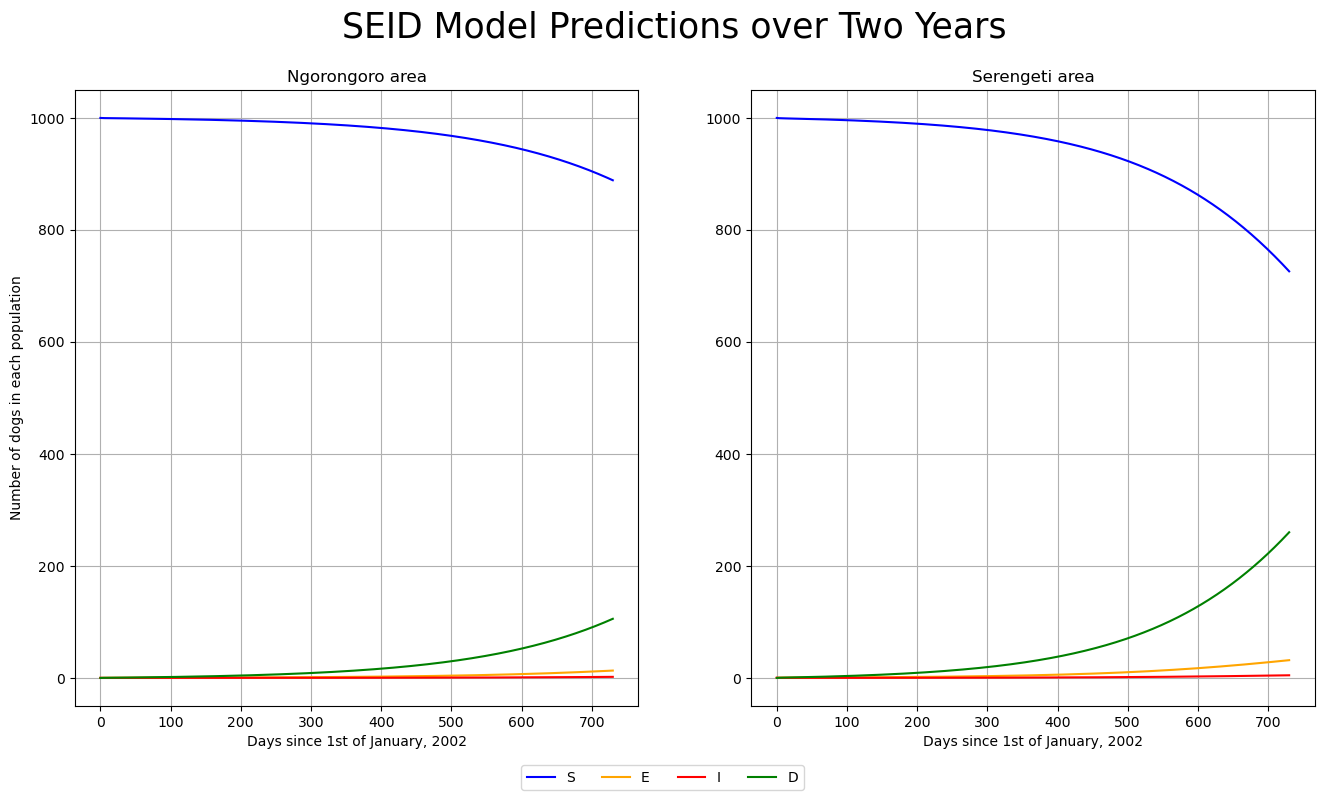

In [58]:
#Defining SEID function
def seid_model(t, variables, parameters):
    # unpacking state variables and parameters
    S, E, I, D = variables
    b, m, alpha, beta, omega = parameters

    # total living population
    N = S + E + I

    # differential equations
    dS = b - beta * S * I / N - m * S
    dE = beta * S * I / N - alpha * E - m * E
    dI = alpha * E - omega * I - m * I
    dD = omega * I

    return [dS, dE, dI, dD]

# establishing time period and initialising variables
simulation_period = (0, 730)
time_stamps = np.linspace(*simulation_period, 731)
area_solutions = {}

#finding solutions for both disctricts
for area in results:
    # creating initial conditions - S=1000, E=0, I=Y0, D=0
    Y0 = results[area]["glm_Y0"]
    initial_conditions = [1000, 0.0, Y0, 0.0]

    # redefining parameters outside of function
    parameters = (b, m, alpha, results[area]["beta"], omega)
    # solving
    solution = solve_ivp(seid_model,simulation_period,initial_conditions,args=(parameters,),method="LSODA",t_eval=time_stamps)
    area_solutions[area] = solution

# Plotting solutions
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
labels = ['S', 'E', 'I', 'D']
colours = ['blue', 'orange', 'red', 'green']

for ax, area in zip(axes, area_solutions):
    sol = area_solutions[area]
    ax.set_title(f"{area} area")
    for i, label in enumerate(labels):
        ax.plot(sol.t, sol.y[i], label=label, color=colours[i])
    ax.set_xlabel("Days since 1st of January, 2002")
    ax.grid(True)

axes[0].set_ylabel("Number of dogs in each population")
fig.suptitle("SEID Model Predictions over Two Years", fontsize = 25)
fig.legend(labels, ncol = 4, loc="lower center")
plt.show()

### f. Write a function seid_deaths that computes cumulative deaths within a set interval

In [59]:
def seid_deaths(time_stamps, initial_conditions, parameters):
    #Function calculates the cumulative number of deaths for each time interval (1 month) but then takes the difference of the adjacenet figures.
    solution = solve_ivp(seid_model,(time_stamps[0], time_stamps[-1]),initial_conditions,args=(parameters,),method="LSODA",t_eval=time_stamps)
    cumulative_deaths = solution.y[3]   
    deaths_per_interval = np.diff(cumulative_deaths)
    return deaths_per_interval



### g. Plotting the recorded monthly cases in each district with the poisson and SEID model predictions 

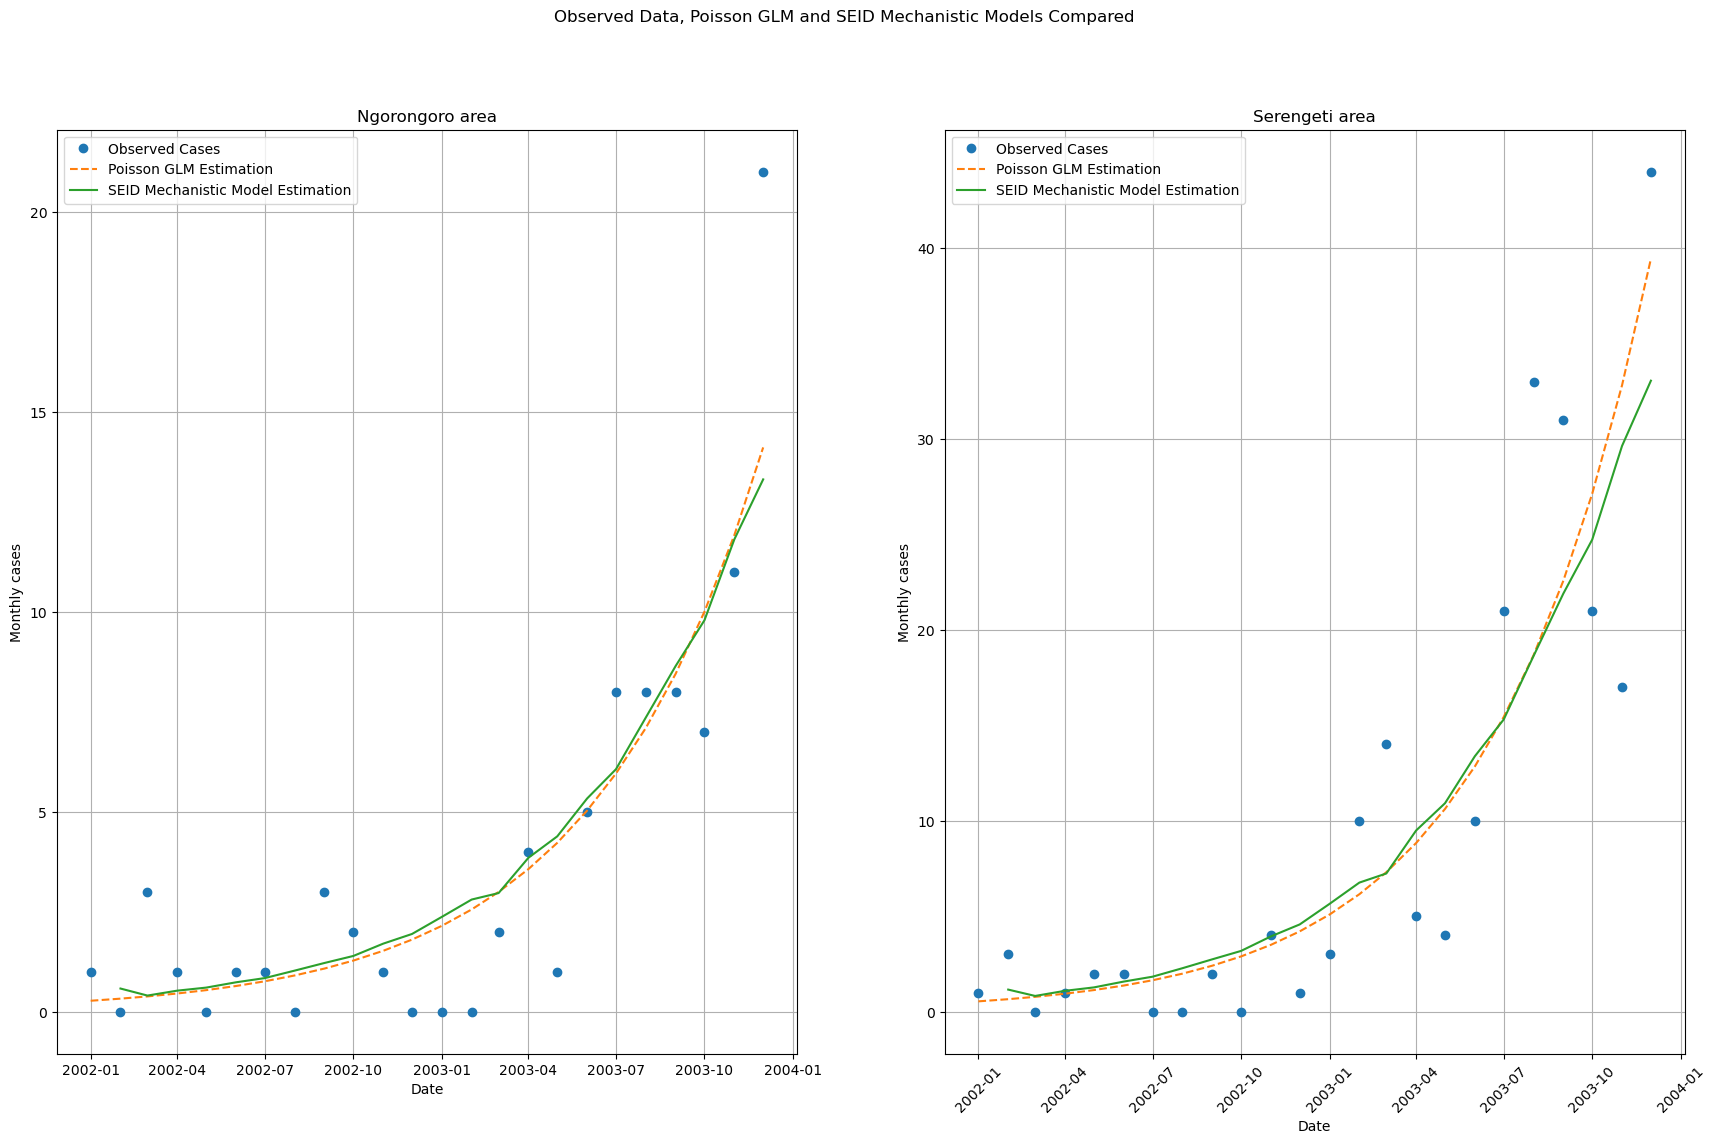

In [60]:
# grabbing pulling out dates and time since start count.
month_dates  = case_reports["Date"]                      
time_stamps  = case_reports["Time_Since_Start"].values #taking .values or the function gets unhappy.

#usual routine for plotting subplots...
fig, axes = plt.subplots(1, 2, figsize=(21, 12))
for ax, area in zip(axes, areas):
    
    # Pulling out the raw observed data for the scatter plot
    observed_cases = case_reports[area].values #taking .values or the function gets unhappy

    # Setting up the poisson function, grabbing Y0 and r ready to put into the function.
    Y0   = results[area]["glm_Y0"]
    r    = results[area]["glm_r"]
    poisson_pred = Y0 * np.exp(r * time_stamps) #making the line for our poisson prediction

    # Setting up for the mechanistic model. 
    initial_conditions = [1000, 0.0, Y0, 0.0]
    parameters = (b, m, alpha, results[area]["beta"], omega)
    seid_pred = seid_deaths(time_stamps, initial_conditions, parameters) #executing seid_deaths to get data for plotting

    # Plotting all three
    ax.plot(month_dates, observed_cases,"o",label="Observed Cases")
    ax.plot(month_dates, poisson_pred, "--", label="Poisson GLM Estimation")
    ax.plot(month_dates[1:], seid_pred,"-", label="SEID Mechanistic Model Estimation")
    ax.set_title(f"{area} area")
    ax.set_xlabel("Date")
    ax.set_ylabel("Monthly cases")
    ax.legend()
    ax.grid(True)

plt.suptitle("Observed Data, Poisson GLM and SEID Mechanistic Models Compared")
plt.xticks(rotation=45)
plt.savefig("task2_1_comparison_graphs")
plt.show()

# Task 2.2 Model Exploration

### a. Plot and describe the model dynamics over a 6 year period

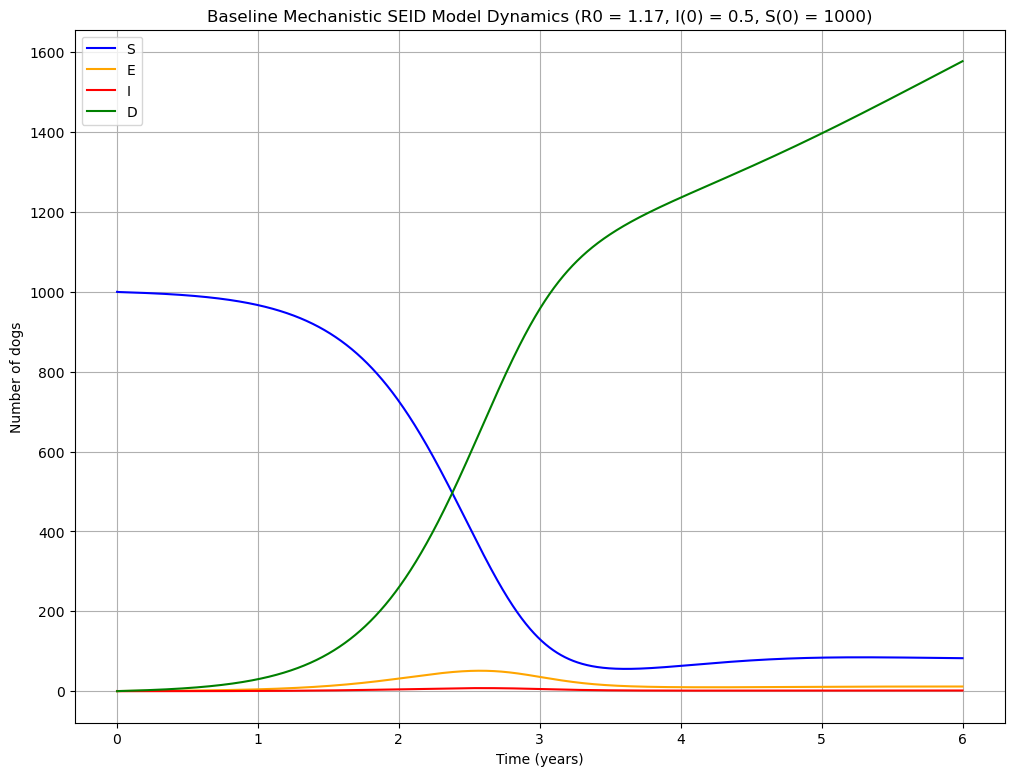

In [61]:
#Plotting the values for each compartment in the model of a 6 year period.
# Establishing baseline values
R0_baseline = 1.17
I0_baseline = 0.5
S0_baseline = 1000
beta_baseline = R0_baseline * (omega + m)

# establishing time frame and setting up range for x values
days_6yr = 6 * 365
time_span = np.arange(0, days_6yr + 1)

# Using run_seid to generate baseline solutions for mechanistic model
baseline_sol = solve_ivp(seid_model,(0, days_6yr),initial_conditions,args=(parameters,),method='LSODA',t_eval=time_span)

#Initiasing figure, compartments, and colours for each compartment
plt.figure(figsize=(12, 9))
compartments = ['S', 'E', 'I', 'D']
colours = ['blue', 'orange', 'red', 'green']

#plotting the line for each compartment generated by the mechanistic model
for compartment in range(4):
    plt.plot(baseline_sol.t/365, baseline_sol.y[compartment], label=compartments[compartment], color=colours[compartment])

#formatting plot
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Number of dogs')
plt.title(f'Baseline Mechanistic SEID Model Dynamics (R0 = {R0_baseline}, I(0) = {I0_baseline}, S(0) = {S0_baseline})')
plt.grid(True)
plt.show()


**Description of model dynamics**

From roughly 0-1.5 years, there is a slow build to the outbreak with little change in S. D is growing slowly but in an exponential fashion.

 The outbreak starts to take off at the 1.5 year mark. Cumulative deaths reach 100 at 1 year,6 months, and 11 days and this doubles within 4 months as deaths reach 200 at 1 year, 10 months, and 13 days. This demonstrates the pace at which the outbreak is progressing even at this early stage. 
 
 The rate at which the number of deaths increases until it seems to reach a quasi linear state at approximately 2 years. Just over 6 months later, deaths reach 500 at 2 years, 4 months, and 21 days. 4 days earlier, the number of deaths exceeds the number of suceptible individuals left in the population. 

 3 months later - at 2 years, 7 months, and 1 day - the number of rabid dogs peaks with 8 dogs. This is the peak of the wave of infections.
 
 4.5 months after that, deaths reach 1000 at 3 years and 29 days. It is at around the 3 year mark that the rate of increase of deaths starts to decrease as there are no longer enough suceptible individuals to maintain the previous rate of increase in deaths. 
 
 Soon after - at 3 years, 7 months, and 10 days — the susceptible population reaches its minimum. This delay arises because new infections take time to progress to death. In other words, dogs infected earlier continue to die even after susceptibles have fallen, so the cumulative death rate temporarily outpaces the rate birth rate (the rate you would expect given the remaining susceptible population). 
 
 After this point, the population increases marginally, since the birth rate now exceeds the death rate. The population then reaches an asymptotic steady state where $\omega I = b$ (the rate of deaths from the disease is equal to the rate of births). This means that the suceptible population remains approximately constant, as does the rate of deaths. This results in the number of cumulate deaths increasing at a steady rate indefinitely, in this case reaching 1577 individuals at the end of the 6 years.

### b., c. and d. Investigating the effects of varying $R_0$, I(0), and S(0) -within a designated range- on key epidemic metrics.

I decided to go with making continuous subplots to demonstrate how each of the metrics changed as a function of the difference in parameter or initial conditions. This allowed for me to visualise how each metric changed with each parameter. Displaying them next to each other also allows for easier comparison between how each parameter effects each metric.

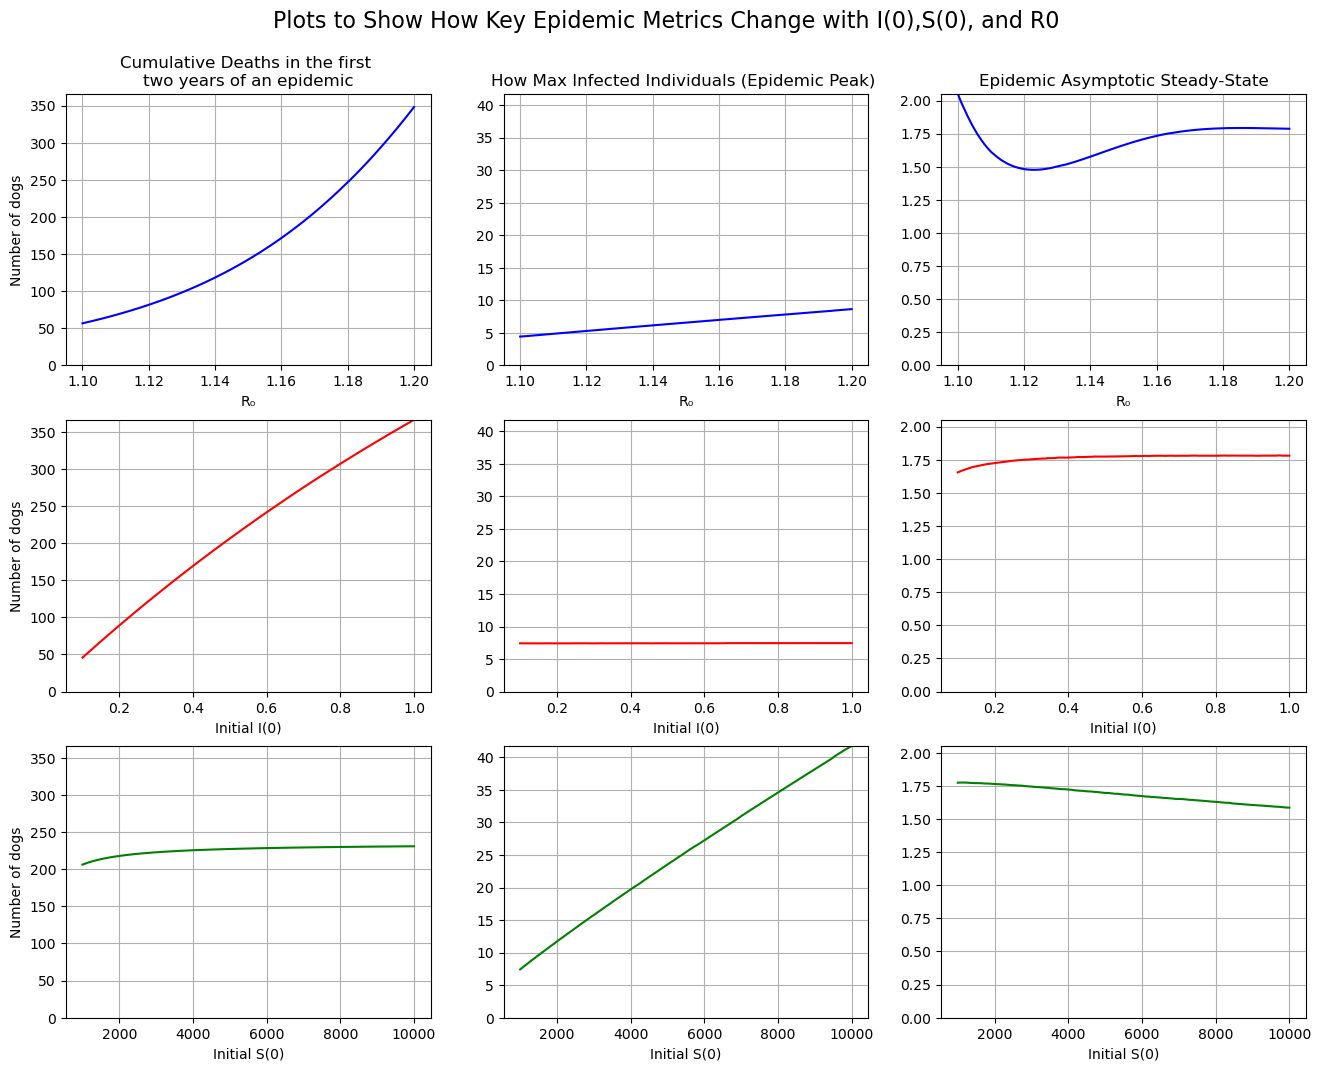

In [62]:
#Now plotting how each parameter affects each metric
# Establishing parameter continuous value ranges for subplots + using the same dict for labelling
parameter_info = {
    "R0": {"values": np.linspace(1.10, 1.20, 100), "label": "R₀"},
    "I0": {"values": np.linspace(0.10, 1.00, 100), "label": "Initial I(0)"},
    "S0": {"values": np.linspace(1000, 10000, 100), "label": "Initial S(0)"}
}

# Initialising dictionary for different epidemic metrics to use to fill every parameter with every metric.
epidemic_metric_results = {} #where I'll store the values for how each parameter affects each metric
metric_names = ["cumulative", "peak", "asymptote"] 

#iterating through each parameter and then adding a field for each metric.
for param in parameter_info:
    #initialising a dictionary for every parameter 
    epidemic_metric_results[param] = {}
    for metric in metric_names:
        epidemic_metric_results[param][metric] = []

# function takes the solution and then selects the metrics that we want for our graphs
def get_metrics(sol):
    S, E, I, D = sol.y # unpacking compartments
    cumulative_deaths = D[729]    #taking the deaths for the first 2 years (or 730 days)
    peak_I = I.max()              #taking the value of the epidemic peak
    asymptote_I = I[-1]           # taking the final value which should be representative of the asymptotic value.
    return cumulative_deaths, peak_I, asymptote_I

#extracting the range of values for each parameter and then setting the intial conditions to match that. Iterating through all options.
for param, data in parameter_info.items():
    for val in data["values"]:
        if param == "R0":
            beta_val = val * (omega + m)
            initial = [S0_baseline, 0.0, I0_baseline, 0.0]
        elif param == "I0":
            beta_val = beta_baseline
            initial = [S0_baseline, 0.0, val, 0.0]
        else:
            beta_val = beta_baseline
            initial = [val, 0.0, I0_baseline, 0.0]

        #Solving differentials for a 6 year timespan and with the intial parameters and args set earlier
        sol = solve_ivp(seid_model,(0, days_6yr),initial,args=((b, m, alpha, beta_val, omega),),method="LSODA",t_eval=time_span)
        
        #Using get_metrics to get process the solutions and get the bits of info we need for the subplots
        cumulative_deaths, peak_I, asymptote_I = get_metrics(sol)
        
        #Saving the data in epidemic metircs dict
        epidemic_metric_results[param]["cumulative"].append(cumulative_deaths)
        epidemic_metric_results[param]["peak"].append(peak_I)
        epidemic_metric_results[param]["asymptote"].append(asymptote_I)

#In order to get uniform y scales for the subplots columns (to make them easy to compare), I need to take the maximum y value for each column and use this to set the axis scale.
# This does this by looping through column by column and stores the max y value.
# This means that it's easier to compare how changing different parameters affects a metric.
col_max = {metric: max(max(epidemic_metric_results[param][metric]) for param in epidemic_metric_results)
           for metric in metric_names}

# Now making the subplots, we have 9 plots so using a 3x3 grid.
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
fig.suptitle("Plots to Show How Key Epidemic Metrics Change with I(0),S(0), and R0", fontsize = 16, y = 0.95)

# Setting up lists for column titles and row colours
param_keys = ["R0","I0","S0"]
col_titles = ["Cumulative Deaths in the first \ntwo years of an epidemic",
              "How Max Infected Individuals (Epidemic Peak) ",
              "Epidemic Asymptotic Steady-State"]
row_colours = ["blue", "red", "green"]

#Using the usual method of iterating through axes to build the subplots.
for ax, title in zip(axes[0], col_titles):
    ax.set_title(title)
#Iterating through rows (and thus parameter type)
for row, param in enumerate(param_keys):
    param_range = parameter_info[param]["values"]
    #Iterating through columns (and thus epidmeic metric) - using enumerate so that I can select each axis
    for col, metric in enumerate(metric_names):
        ax = axes[row, col]
        metric_outputs = epidemic_metric_results[param][metric]
        ax.plot(param_range, metric_outputs, color=row_colours[row])
        ax.set_ylim(0, col_max[metric]) #using the col max which was defined earlier
        ax.grid(True)
        ax.set_xlabel(parameter_info[param]["label"])
        #only setting the ylabel for the first col of graphs. Makes it look all pretty! (and avoid repetition)
        if col == 0: 
            ax.set_ylabel("Number of dogs")
plt.show()

**Breakdown of the Plots**

The top row of plots demonstrate how the basic reproduction number affects the Cumulative Deaths, Epidemic Peak, and Asymptotic Steady State of a disease outbreak which is modelling by our SEID model, in this case modelling a rabies outbreak. The next two rows demonstrate the effect of changing the number of susceptible and infected individuals in initial population of the outbreak affect the same metrics for our SEID model. 

Looking by column, can allow you to see how each of these initial conditions effect one epidemic metric. 

### e. Investigating when b=m=0 

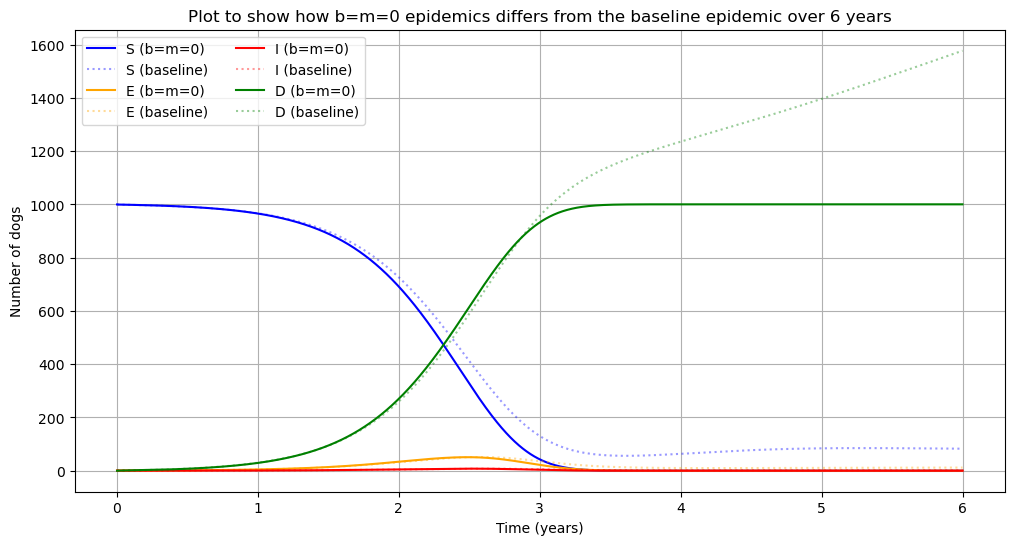

In [63]:
#solving differnetial equations for where b and m equal zero 
sol_no_b_m = solve_ivp(seid_model, (0, days_6yr), [S0_baseline, 0.0, I0_baseline, 0.0], args=((0.0, 0.0, alpha, beta_baseline, omega),), method='LSODA', t_eval=time_span)

plt.figure(figsize=(12, 6))
for compartment, label, colour in zip(range(4), ['S','E','I','D'], ['blue','orange','red','green']):
     plt.plot(sol_no_b_m.t/365, sol_no_b_m.y[compartment], label=f'{label} (b=m=0)', color=colour)
     #also plotting a dotted transparent line for the baseline solutions for comparison
     plt.plot(baseline_sol.t/365, baseline_sol.y[compartment], label=f'{label} (baseline)', color=colour, linestyle=':', alpha = 0.4) 

plt.xlabel('Time (years)')
plt.ylabel('Number of dogs')
plt.title('Plot to show how b=m=0 epidemics differs from the baseline epidemic over 6 years')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.show()

*The baseline epidemic is that plotted in Task 2.2 a) and uses an outbreak model which includes natural birth and death rates.

The outbreak dynamics remain very similar in the beginning of the outbreak, this can be shown since the lines don't diverge significantly until around the 2 year mark.At this point the number of susceptible indivduals in each outbreak begins to diverge, with the baseline outbreak having more susceptible indivduals, due to the fact that some people are being born into the populaiton. At ~3 years, the baseline population reaches equilibrium of ~100 dogs. This is the point where the rate of births is roughly equal to the rate of natural and rabies related death. Contastingly, since there are no new births in the b=m=0 population, the entire population become infected and die (since there is no influx into the susceptible population). This leads to an steady state of 1000 dogs in the D population and 0 in the S population.  

### f. Discussing the differences with a standard SEIR model

$$
\begin{aligned}
\frac{dS}{dt} &= b - \frac{\beta\,S\,I}{N} - m\,S \\
\frac{dE}{dt} &= \frac{\beta\,S\,I}{N} - \alpha\,E - m\,E \\
\frac{dI}{dt} &= \alpha\,E - \gamma\,I - m\,I \\
\frac{dR}{dt} &= \gamma\,I - m\,R
\end{aligned}
$$

where:

- N = S+E+I+R
- $b$ is the birth rate into the susceptible class
- $\beta$ is the transmission rate (per contact)
- $\alpha$ is the rate at which exposed individuals become infectious  
- $\gamma$ is the recovery rate  
- $m$ is the natural death rate  



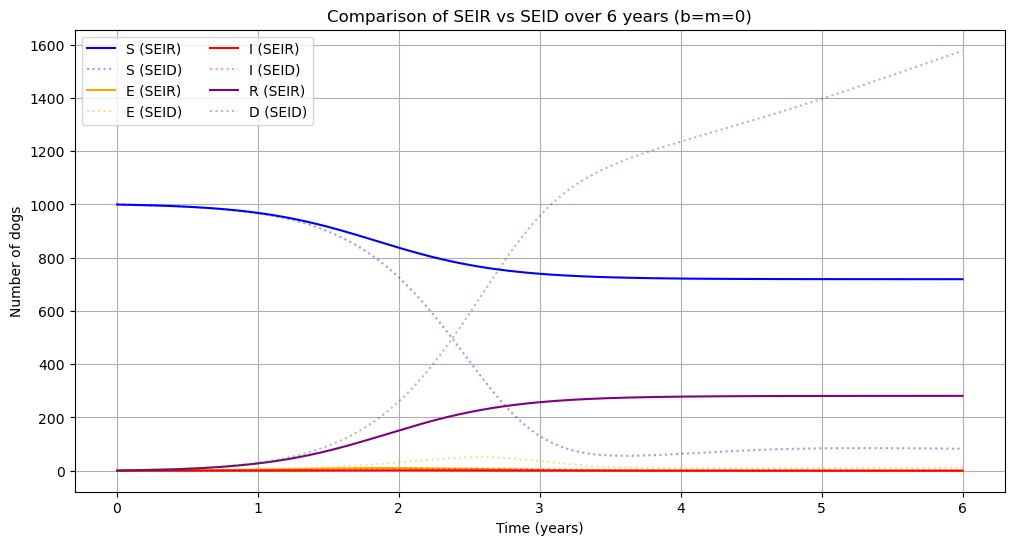

In [64]:
#Defining function for SEIR Model
def seir_model(t, variables, parameters):
    # unpack state variables and parameters
    S, E, I, R = variables
    b, m, alpha, beta, gamma = parameters

    # total population
    N = S + E + I + R

    # differential equations
    dS = b - beta * S * I / N - m * S
    dE = beta * S * I / N - alpha * E - m * E
    dI = alpha * E - gamma * I - m * I
    dR = gamma * I - m * R

    return [dS, dE, dI, dR]

#solving differnetial equations for where b and m equal zero 
sol_seir = solve_ivp(seir_model, (0, days_6yr), [S0_baseline, 0.0, I0_baseline, 0.0], args=((0.0, 0.0, alpha, beta_baseline, omega),), method='LSODA', t_eval=time_span)

#setting up lists for the labels and colours for each compartment so that I can loop through each compartment
seir_labels = ['S', 'E', 'I', 'R']
seid_labels = ['S', 'E', 'I', 'D']
seid_colours = ['blue', 'orange', 'red', 'green']
seir_colours = ['blue', 'orange', 'red', 'purple']

#plotting
plt.figure(figsize=(12, 6))
seid_sol = baseline_sol # renaming for easy interpretation

#looping through each compartment
for compartment, (seir_label, seid_label, seir_colour, seid_colour) in enumerate(zip(seir_labels, seid_labels, seir_colours, seid_colours)):
    plt.plot(sol_seir.t/365, sol_seir.y[compartment], label=f'{seir_label} (SEIR)', color=seir_colour)
    #also plotting a dotted transparent line for the baseline solutions for comparison
    plt.plot(seid_sol.t/365, seid_sol.y[compartment], label=f'{seid_label} (SEID)', color=seid_colour, linestyle=':', alpha=0.4)

plt.xlabel('Time (years)')
plt.ylabel('Number of dogs')
plt.title('Comparison of SEIR vs SEID over 6 years (b=m=0)')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.show()

**Comparing SEIR and SEID Models**

The outbreak dynamics in an SEIR and SEID and starkly different. Due to the fact that recovered individuals are assumed to be totally immune to the disease, these individuals remain in the population but are not able to be infected or transmit the disease. This means that infections occur at a visibly slower rate after ~18 months. The number of cases reach their steady state at around the same timestamp, ~3 years, however far fewer of the susceptible population are infected since the recovered indivduals are able to create herd immunity, preventing the disease from spreading any further. This demonstrates that rabies' 100% fatality rate has a significant impact on the outbreak dynamic compared to diseases where people recover.

**The Relevance of Herd Immunity and Vaccination**

This is the first time in the project that we encounter the principle of herd immunity. This is immediately relevant when considering using vaccination as a method to prevent infections. This is because vaccination allows us to create immunity in individuals who have not had the disease, and thus vaccination allows us to limit the pathogenic effects on the individual and the population as a whole (through herd immunity).

Kermack and McKendrick derived a relationship between $R_0$ and the percentage of vaccinated individuals required (assuming vaccination is perfectly effective) to establish herd immunity. Their derivation follows below:

*Critical Susceptible Fraction* $\rightarrow$ The maximum proportion of the population that can be susceptible without an outbreak growing. 

*Critical Vaccination Threshold* $\rightarrow$ The minimum proportion of the population that must immune to the disase to prevent sustained outbreak growth.

$$
\text{Where } i(t) = \frac{I(t)}{N} 
$$

$$
0 = \frac{di}{dt} = \beta s i - \gamma i
$$


$$
\frac{\beta s}{\gamma} = 1
$$

Then solving for the **Critical Susceptible Fraction**:

$$
s_{\text{critical}} = \frac{\gamma}{\beta} = \frac{1}{R_0}
$$


The **Critical Vaccination Threshold ($V$)** can then be deduced as:

$$
V = 1 - s_{\text{critical}} = 1 - \frac{1}{R_0}
$$

In this case, since $R_0$ = 1.17, we can calculate:
$$
V = 1-\frac{1}{1.17} \approx 0.145
$$

As we can see from the Critical Vaccination Threshold above, because the $R_0$ is only 1.17 (SARS-CoV-2 lies in the range of 2.79-3.28 [1]) the critical vaccination is low, only 14.5%. This suggests that vaccination could be a very effective strategy to combat Rabies epidemics. Hampson et al. comes to similar conclusions, although their estimates for the critical vaccination threshold are higher “From our estimates of R0, we calculate the deterministic critical vaccination threshold for rabies elimination in rural Tanzania to be only 20% (P crit = 1 – 1/R0), and even in areas where R0 is higher, P crit rises to just 40%"[2].



# Part 3

### a. Write a function to implement the Gillespie algorithm for the SEID model.

In [65]:
def SEID_sim(t_max, init, par, seed):
 # also includes an input for the seed of the rng. 
    rng = np.random.default_rng(seed)

    # unpack parameters
    b, m, alpha, beta, omega = par
    X = np.array(init)
    S, E, I, D = X
    t = 0
    # initial state
    times = np.array([0.0])
    sol = np.array([init])

    events = [
        [1, 0, 0, 0], #birth
        [-1, 1, 0, 0], #infection
        [0, -1, 1, 0],#emergence
        [-1, 0, 0, 0], #S natural death
        [0, -1, 0, 0], #E natural death
        [0, 0, -1, 0], #I natural death
        [0, 0, -1, 1] #Rabies death
    ]

    while t < t_max: 
        N = S + E + I
        #rates of each event:
        rates= np.array([b, # birth
                        beta*S*I/N, #infection
                        alpha*E, #emergence
                        m*S, #S natural death
                        m*E, #E natural death
                        m*I, #I natural death
                        omega*I # Rabies Death
                        ])
        if rates.sum() <= 0:
            break
        #next time step
        u = rng.exponential(1/(rates.sum()))
        #storing next value of t
        t = t+u
        times = np.append(times,t)

        #choose the next event
        z = rng.choice(rates.size, p = rates/rates.sum())
        #updating state variables accordingly:
        X = S, E, I, D = X + np.array(events[z])

        #storing new states
        sol = np.append(sol, [X], axis = 0)

        # Ensuring no negative populations.
        S = max(0, S)
        E = max(0, E)
        I = max(0, I)
        X = np.array([S, E, I, D])

    return times, sol


### b. Running and plotting 100 sims for 2 year period

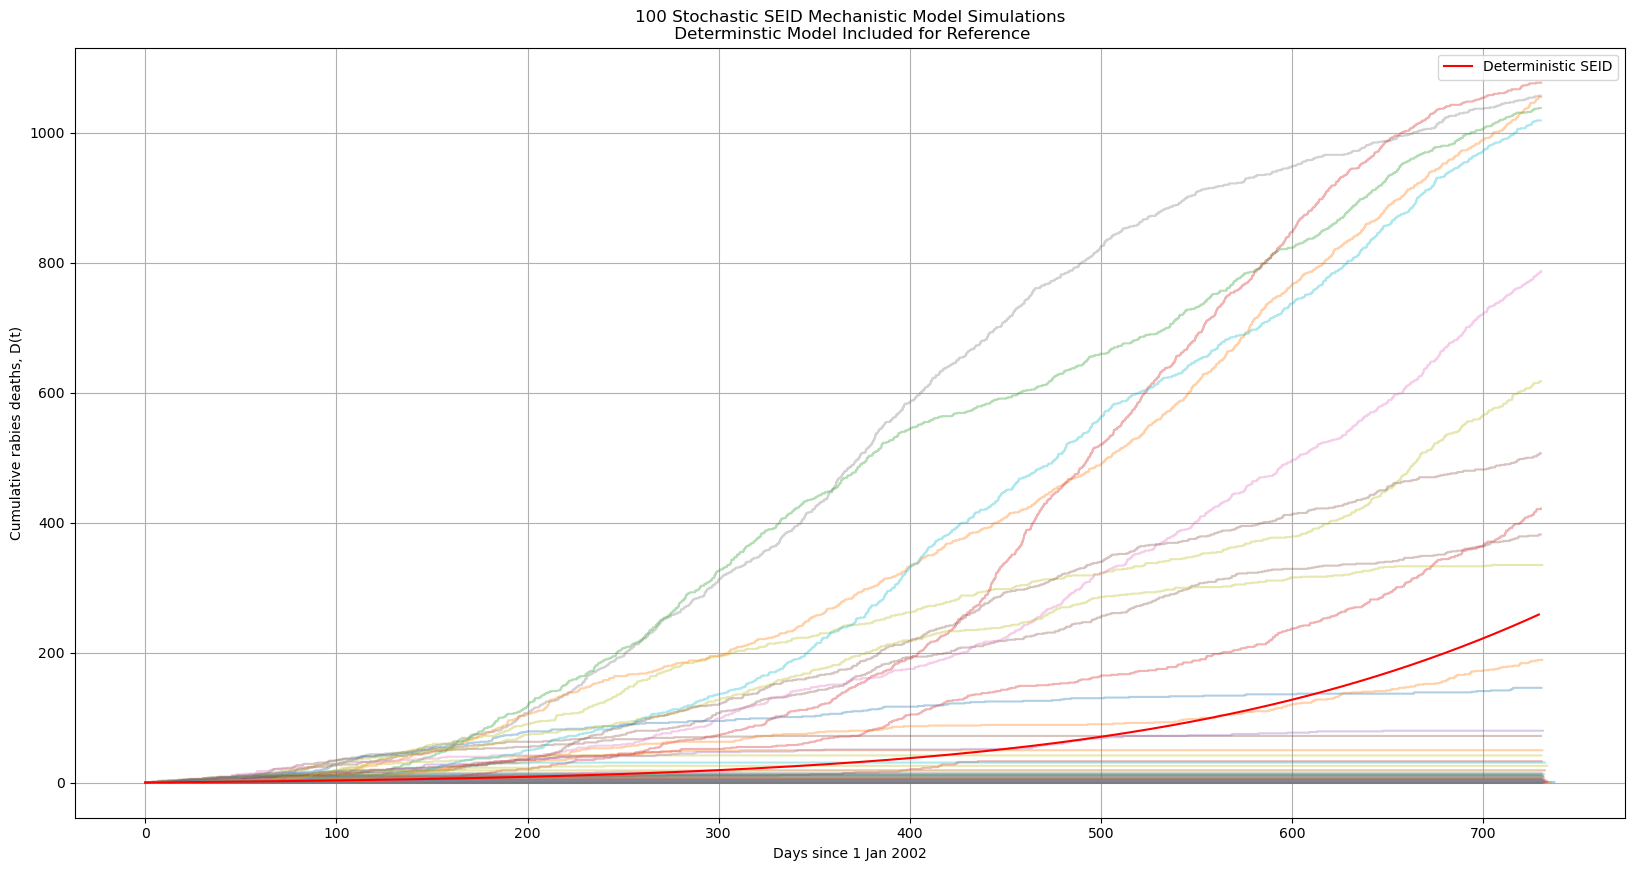

In [66]:
#setting up params and intial conditions
par = (b, m, alpha, beta_baseline, omega)
init = [1000, #S = 1000
         0, # E = 0
         0.5, # I = 0.5
         0 # D = 0
         ] 
t_max = 365*2  #two years
n_sims = 100
final_deaths = np.zeros(n_sims)
all_times = []
all_events = []

# running model and plotting graph (if asked for)
def run_and_plot_stochastic_sims(parameters, initial_conditions ,n_sims = 100, time_span = 730, seed = 100, plot = True ):
    if plot: #only setting up plot stuff if plot = True
        fig, ax = plt.subplots(figsize=(20, 10))
    for i in range(n_sims):
        # Give each run its own seed so trajectories differ each time
        seed = seed + i
        t_sim, X_sim = SEID_sim(time_span, initial_conditions, parameters, seed)
        all_times.append(t_sim)
        all_events.append(X_sim)
        if plot:
            ax.step(t_sim, X_sim[:, 3], where="post", alpha=0.35)
    if plot:
        # adding in deterministic solution
        ax.plot(baseline_sol.t[:730], baseline_sol.y[3][:730], color="red", label="Deterministic SEID")

        # labels, titles, and such
        ax.set_xlabel("Days since 1 Jan 2002")
        ax.set_ylabel("Cumulative rabies deaths, D(t)")
        ax.set_title(f"{n_sims} Stochastic SEID Mechanistic Model Simulations\n Determinstic Model Included for Reference")
        ax.legend()
        ax.grid(True)
        plt.show()
    return all_times, all_events

event_times, sim_solutions = run_and_plot_stochastic_sims(par, init)

**How the determinstic model differs from the stochastic model**

The above graph demonstrates how significantly stochastic epidemic modelling differes from deterministic epidemic modelling. The solid red line demonstrates the outcome of a determinstic model whereas the stochastic models' epidemic predictions are the other sprectrum of colours.
We can see that the stochastic model does a far better job at demonstrating, that even if there is an infected individual, that outbreaks do not always become large scale events, and many die out before they are able to properly take grip in the population. They also demonstrate how it's possible for outbreaks to vary significantly in size even if they do take hold in the population: some cause well over 1000 deaths, many more cause fewer than 100. Overall, the ability of a stochastic model random chance makes it far better at modelling the wide spectrum of possible outcomes of an outbreak.

### d. Calculating the the probability of early extinction

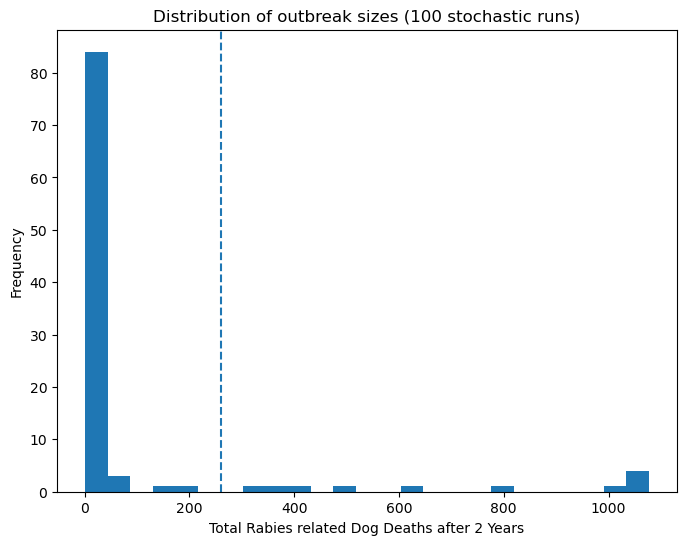

In [67]:
# creating a function to plot the final sizes of different epidemics whilst also returning how many epidemics became extinct early
def gather_and_plot_epidemic_size_info(par, init, n_sims = 100, early_extinction_threshold = 10):
    #intialising returned arrays
    early_extinction_events = np.zeros(n_sims) 
    final_deaths = np.zeros(n_sims)
    #running sims with input parameters
    all_times, all_events = run_and_plot_stochastic_sims(par, init, n_sims = n_sims, plot = False)
    #iterating through the results to get a array of the final deaths and early
    #I chose to do this as a seperate function to the one above since I didn't returning final deaths with every time I wanted to plot the graph. 
    # I appreciate this is considerably more computationally expensive.
    for i in range(n_sims):
        final_deaths[i] = all_events[i][-1, 3]
        early_extinction_events[i] = final_deaths[i] < early_extinction_threshold
    #Plotting
    deterministic_model_final_deaths = baseline_sol.y[3, 730]
    plt.figure(figsize=(8, 6))
    plt.hist(final_deaths, bins=25)
    plt.axvline(deterministic_model_final_deaths, linestyle="dashed")
    plt.xlabel("Total Rabies related Dog Deaths after 2 Years")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of outbreak sizes ({n_sims} stochastic runs)")
    return final_deaths, early_extinction_events, deterministic_model_final_deaths

n_sims = 100
early_extinction_threshold = 10
final_deaths, early_extinction_events, deterministic_model_final_deaths= gather_and_plot_epidemic_size_info(par, init, n_sims = n_sims, early_extinction_threshold = early_extinction_threshold)

In [68]:

early_extinction_percentage = 100* early_extinction_events.mean()

print("Deterministic model deaths after 2 years: "f"{deterministic_model_final_deaths:.1f}")
print(f"Simulated mean deaths: {final_deaths.mean():.1f}")
print(f"Median deaths: {np.median(final_deaths):.1f}")
print(f"Early‑extinction threshold < {early_extinction_threshold} deaths")
print(f"Simulated early‑extinction probability: {early_extinction_percentage}%")




Deterministic model deaths after 2 years: 260.1
Simulated mean deaths: 92.1
Median deaths: 2.0
Early‑extinction threshold < 10 deaths
Simulated early‑extinction probability: 73.0%


My results suggest that there is a 73% chance of the outbreak not causing more than 10 deaths. I used less than 10 deaths as a threshold since this represents 1% of the population, what I would constitute as not a *large* outbreak. 

### e. Considering the validity of using a single outbreak for parameter estimation.
Our stochastic model demonstrates how much an outbreak of the same disease with the same initial conditions can vary due to random chance, 73% of outbreaks cause fewer than 10 deaths whereas a very small proportion of outbreaks go on to cause over 1000 deaths. This demonstrates the huge variation that can occur during outbreaks due to random chance, this has a number of consequences for using a single outbreak to calculate parameter estimates.

One consequence of outbreaks being so variable in size due to random chance means that we will have very large confidence intervals for our estimated parameters. This is because the key epidemic metrics which are often used to estimate parameters (such as $R_0$) vary massively from outbreak to outbreak. Thus, when we only take data from a single outbreak we must have very large confidence intervals in order to acknowledge how that single outbreak may not be representative of the disease generally. The issue of large confidence intervals is particularly true when using an outbreak with a small population. This is because the coefficient of variation $CV$ in a birth-death model, like ours above, increases with a small population. See the below:

The coefficient of variation of $X_t$ in the birth–death process is given by:

$$
CV(X_t)
= \sqrt{\frac{b + \mu}{X_0\,(b - \mu)}\bigl(1 - e^{-(b - \mu)\,t}\bigr)}.
$$

Where $b$ = birth rate per individual, $\mu$ = death rate (the combined rate of death due to natural and disease related causes), and $t$ = the time since the start of the process.

Thus as $X_0$ increases, $CV$ decreases. Thus, if you are estimating parameters from a single outbreak, it is important that you consider an outbreak with a large initial population since this can help to reduce the confidence intervals in your parameter estimations.

There is also substantial suviourship bias towards which outbreaks are chosen to be studied since the ones that are recorded tend to be the largest outbreaks of the disease, and the vast majority of outbreaks go unrecorded beacsue they die out before they are noticable. This bias means that only choosing one outbreak means you will likely be picking a close to "worst case" scenario and thus your parameter estimations, such as generation time, will likely be shifted upwards accordingly.

Additionally, parameter estimation from a single outbreak has another significant flaw. Parameters, such as $R_0$ can vary from environment to environment, based on factors such as humidity and temperature. Thus, taking data from a single outbreak, and thus a single environment, makes it very difficult to estimate the disease's behaviour in other environments. This can be evidenced by COVID's estimated $R_0$, despite being very well researched, varying from 2.79-3.28 [1]. This demonstrates how $R_0$, and other parameters, can vary a great deal based on their environment. Thus, making a model from a single outbreak can mean that your model is only valid for that dataset's specific environmental parameters. By taking data from more outbreaks you are able to better model the effect of these environmental variances on the disease.

Because of all of the factors above, there are significant limitations to parameter estimations based on data from a single outbreak. However, there are steps that can be taken to mitigate these factors. For example, Hampson et al estimate $R_0$ through a variety of measures such as ensuring comparing your values are in line with global estimations, such as what is done in Hampson et al's resarch [2]. 

All in all, stochasicity is a factor that must be accounted for in disease outbreaks and taking data from a single outbreak makes this particularly difficult. Steps can be taken to help mitigate these difficulties, such as ensuring the population has a large initial population and checking that your parameter estimations align with global estimations.

# Bibliography
[1]	Achaiah NC, Subbarajasetty SB, Shetty RM. R₀ and Rₑ of COVID‑19: Can we predict when the pandemic outbreak will be contained? Indian J Crit Care Med. 2020;24(11):1125–1127. doi:10.5005/jp-journals-10071-23649

[2] Hampson K, Dushoff J, Cleaveland S, et al. Transmission dynamics and prospects for the elimination of canine rabies. PLoS Biol. 2009 Mar 10;7(3):e53. doi:10.1371/journal.pbio.1000053


